## Imports and Environment Setup

### kaggle api reference
https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md

In [1]:
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import TYPE_CHECKING, Optional, List, Dict, Any, Callable, Union, Tuple
import lightgbm as lgb
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gc
import optuna
import dill
import warnings
import datetime
warnings.filterwarnings('ignore')

In [2]:
f"pandas {pd.__version__}, polars {pl.__version__}, numpy {np.__version__}, lightgbm {lgb.__version__}, xgboost {xgb.__version__}, optuna {optuna.__version__}"

'pandas 2.2.3, polars 1.6.0, numpy 2.0.2, lightgbm 4.5.0, xgboost 2.1.1, optuna 4.0.0'

In [3]:
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
if not IS_KAGGLE: 
    os.chdir('./kaggle')
    from kaggle.api.kaggle_api_extended import KaggleApi
BASE_PATH = '/kaggle/input/jane-street-real-time-market-data-forecasting' if IS_KAGGLE else './data'
MODEL_PATH = '/kaggle/working' if IS_KAGGLE else './models'

In [4]:
IS_KAGGLE, BASE_PATH, MODEL_PATH

(False, './data', './models')

In [5]:
if TYPE_CHECKING:
    from __main__ import Config, ModelConfig

#### Define Metrics

In [6]:
def r2_metric(y_true, y_pred, weights=None):
    """Calculate weighted R2 score"""
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # If weights is None, use uniform weights
    if weights is None:
        weights = np.ones_like(y_true)
    else:
        weights = weights.ravel()

    numerator = np.sum(weights * (y_true - y_pred) ** 2)
    denominator = np.sum(weights * (y_true ** 2))
    r2_score = 1 - (numerator / denominator)
    return 'r2', r2_score, True

#### Version control

In [7]:
from functools import wraps

def versioned_function(version: str, description: str = ""):
    """Function versioning decorator"""
    def decorator(func: Callable) -> Callable:
        @wraps(func)
        def wrapper(*args, **kwargs):
            return func(*args, **kwargs)
        
        wrapper.version = version
        wrapper.description = description
        return wrapper
    return decorator

## Model Class

In [8]:
class BaseModel:
    """Base model class for easy extension"""
    def __init__(self, config: "ModelConfig"):
        self.config = config
        self.model = None
        self._register_custom_metrics()
    
    def _register_custom_metrics(self):
        """Register custom metrics if needed"""
        pass
    
    def fit(self, train_data: Tuple[np.ndarray, np.ndarray], 
           val_data: Optional[Tuple[np.ndarray, np.ndarray]] = None):
        raise NotImplementedError
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
    def save(self, path: str):
        with open(path, 'wb') as f:
            dill.dump(self.model, f)
    
    def load(self, path: str):
        with open(path, 'rb') as f:
            self.model = dill.load(f)

class LightGBMModel(BaseModel):
    def _register_custom_metrics(self):
        """Register custom metrics for LightGBM"""
        # Instead of registering metrics directly, we'll add them to params
        if self.config.custom_metrics:
            self.config.params['metric'] = list(self.config.custom_metrics.keys())
    
    def fit(self, train_data: Tuple[np.ndarray, np.ndarray, np.ndarray], 
           val_data: Optional[Tuple[np.ndarray, np.ndarray, np.ndarray]] = None):
        train_X, train_y, train_w = train_data
        print(f"\nMemory usage before training:")
        print(f"train_X: {train_X.nbytes / 1024 / 1024 / 1024:.2f} GB")
        print(f"train_y: {train_y.nbytes / 1024 / 1024 / 1024:.2f} GB")
        if train_w is not None:
            print(f"train_w: {train_w.nbytes / 1024 / 1024 / 1024:.2f} GB")
        
        train_set = lgb.Dataset(train_X, train_y, weight=train_w, free_raw_data=False, params={'feature_pre_filter': False})
        
        del train_X, train_y, train_w, train_data
        gc.collect()
        
        val_set = None
        if val_data is not None:
            val_X, val_y, val_w = val_data
            print(f"\nValidation data memory usage:")
            print(f"val_X: {val_X.nbytes / 1024 / 1024 / 1024:.2f} GB")
            print(f"val_y: {val_y.nbytes / 1024 / 1024 / 1024:.2f} GB")
            if val_w is not None:
                print(f"val_w: {val_w.nbytes / 1024 / 1024 / 1024:.2f} GB")
            val_set = lgb.Dataset(val_X, val_y, weight=val_w, free_raw_data=False, params={'feature_pre_filter': False})
            
            del val_X, val_y, val_w, val_data
            gc.collect()
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
        
        self.model = lgb.train(
            self.config.params,
            train_set,
            num_boost_round=1000,
            valid_sets=[val_set] if val_set else None,
            valid_names=['valid'] if val_set else None,
            callbacks=callbacks
        )
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.model.predict(X)

class XGBoostModel(BaseModel):
    def _register_custom_metrics(self):
        """Register custom metrics for XGBoost"""
        if self.config.custom_metrics:
            self.config.params['custom_metric'] = list(self.config.custom_metrics.values())
    
    def fit(self, train_data: Tuple[np.ndarray, np.ndarray, np.ndarray], 
           val_data: Optional[Tuple[np.ndarray, np.ndarray, np.ndarray]] = None):
        """Train XGBoost model"""
        train_X, train_y, train_w = train_data
        train_set = xgb.DMatrix(train_X, train_y, weight=train_w)
        
        del train_X, train_y, train_w
        gc.collect()
        
        watchlist = [(train_set, 'train')]
        if val_data is not None:
            val_X, val_y, val_w = val_data
            val_set = xgb.DMatrix(val_X, val_y, weight=val_w)
            watchlist.append((val_set, 'valid'))
            
            del val_X, val_y, val_w
            gc.collect()
        
        self.model = xgb.train(
            self.config.params,
            train_set,
            num_boost_round=1000,
            evals=watchlist,
            early_stopping_rounds=100,
            verbose_eval=100
        )
        
        del train_set
        if val_data is not None:
            del val_set
        gc.collect()
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        return self.model.predict(xgb.DMatrix(X))

# Example model implementations
"""
class EnsembleModel(BaseModel):
    def __init__(self, config: "ModelConfig", models: List[BaseModel]):
        super().__init__(config)
        self.models = models
    
    def _register_custom_metrics(self):
        # 각 모델의 custom metrics는 이미 등록되어 있음
        pass
    
    def fit(self, train_data: Tuple[np.ndarray, np.ndarray], 
           val_data: Optional[Tuple[np.ndarray, np.ndarray]] = None):
        for model in self.models:
            model.fit(train_data, val_data)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = [model.predict(X) for model in self.models]
        # Weighted average if weights are specified in config
        weights = self.config.params.get('weights', None)
        if weights is not None:
            return np.average(predictions, axis=0, weights=weights)
        return np.mean(predictions, axis=0)
"""

'\nclass EnsembleModel(BaseModel):\n    def __init__(self, config: "ModelConfig", models: List[BaseModel]):\n        super().__init__(config)\n        self.models = models\n    \n    def _register_custom_metrics(self):\n        # 각 모델의 custom metrics는 이미 등록되어 있음\n        pass\n    \n    def fit(self, train_data: Tuple[np.ndarray, np.ndarray], \n           val_data: Optional[Tuple[np.ndarray, np.ndarray]] = None):\n        for model in self.models:\n            model.fit(train_data, val_data)\n    \n    def predict(self, X: np.ndarray) -> np.ndarray:\n        predictions = [model.predict(X) for model in self.models]\n        # Weighted average if weights are specified in config\n        weights = self.config.params.get(\'weights\', None)\n        if weights is not None:\n            return np.average(predictions, axis=0, weights=weights)\n        return np.mean(predictions, axis=0)\n'

In [9]:
class MLPModel(nn.Module):
    """Basic MLP architecture"""
    def __init__(self, input_dim: int, hidden_dims: List[int], dropout: float = 0.1):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x).squeeze()

class NeuralNetworkModel(BaseModel):
    def _register_custom_metrics(self):
        """Register custom metrics for Neural Network"""
        pass
    
    def fit(self, train_data: Tuple[np.ndarray, np.ndarray, np.ndarray], 
           val_data: Optional[Tuple[np.ndarray, np.ndarray, np.ndarray]] = None):
        """Train Neural Network model"""
        # Clear GPU cache before training
        torch.cuda.empty_cache()
        
        train_X, train_y, train_w = train_data
        
        # Convert to PyTorch tensors
        train_X = torch.FloatTensor(train_X)
        train_y = torch.FloatTensor(train_y.reshape(-1))
        train_w = torch.FloatTensor(train_w.reshape(-1)) if train_w is not None else None
        
        # Create model
        if self.model is None:
            self.model = MLPModel(
                input_dim=train_X.shape[1],
                hidden_dims=self.config.params.get('hidden_dims', [256, 128, 64]),
                dropout=self.config.params.get('dropout', 0.1)
            )
        
        # Move to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\nUsing device: {device}")
        self.model = self.model.to(device)
        
        # Create data loaders with pin_memory
        train_dataset = TensorDataset(train_X, train_y) if train_w is None else TensorDataset(train_X, train_y, train_w)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.config.params.get('batch_size', 256),
            shuffle=True,
            pin_memory=True,
            num_workers=24
        )
        print(f"Number of training batches: {len(train_loader)}")
        
        val_loader = None
        if val_data is not None:
            val_X, val_y, val_w = val_data
            val_X = torch.FloatTensor(val_X)
            val_y = torch.FloatTensor(val_y.reshape(-1))
            val_w = torch.FloatTensor(val_w.reshape(-1)) if val_w is not None else None
            
            val_dataset = TensorDataset(val_X, val_y) if val_w is None else TensorDataset(val_X, val_y, val_w)
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.config.params.get('batch_size', 256),
                shuffle=False,
                pin_memory=True,
                num_workers=24
            )
            print(f"Number of validation batches: {len(val_loader)}")
        
        # Setup training
        optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.config.params.get('learning_rate', 1e-3),
            weight_decay=self.config.params.get('weight_decay', 1e-5)
        )
        criterion = nn.MSELoss(reduction='none')
        
        best_val_loss = float('inf')
        patience = self.config.params.get('patience', 10)
        patience_counter = 0
        
        # Training loop
        epochs = self.config.params.get('epochs', 100)
        print("\nStarting training...")
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            batch_count = 0
            
            for batch in train_loader:
                optimizer.zero_grad()
                
                if len(batch) == 3:  # with weights
                    x_batch, y_batch, w_batch = [b.to(device, non_blocking=True) for b in batch]
                    y_pred = self.model(x_batch)
                    loss = (criterion(y_pred, y_batch) * w_batch).mean()
                else:  # without weights
                    x_batch, y_batch = [b.to(device, non_blocking=True) for b in batch]
                    y_pred = self.model(x_batch)
                    loss = criterion(y_pred, y_batch).mean()
                
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                batch_count += 1
            
            train_loss /= batch_count
            
            # Validation
            if val_loader is not None:
                self.model.eval()
                val_loss = 0
                val_batch_count = 0
                
                with torch.no_grad():
                    for batch in val_loader:
                        if len(batch) == 3:  # with weights
                            x_batch, y_batch, w_batch = [b.to(device, non_blocking=True) for b in batch]
                            y_pred = self.model(x_batch)
                            loss = (criterion(y_pred, y_batch) * w_batch).mean()
                        else:  # without weights
                            x_batch, y_batch = [b.to(device, non_blocking=True) for b in batch]
                            y_pred = self.model(x_batch)
                            loss = criterion(y_pred, y_batch).mean()
                        val_loss += loss.item()
                        val_batch_count += 1
                
                val_loss /= val_batch_count
                
                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # Print progress every epoch
                print(f'Epoch {epoch+1}/{epochs}: train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}, best_val_loss = {best_val_loss:.4f}')
                
                if patience_counter >= patience:
                    print(f'\nEarly stopping at epoch {epoch+1}')
                    break
            else:
                print(f'Epoch {epoch+1}/{epochs}: train_loss = {train_loss:.4f}')
            
            # Periodic cache clearing
            if epoch % 5 == 0:
                torch.cuda.empty_cache()
        
        print("\nTraining completed!")
        
        # Clear memory
        del train_X, train_y, train_w, train_loader
        if val_data is not None:
            del val_X, val_y, val_w, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions in batches with memory optimization"""
        self.model.eval()
        predictions = []
        batch_size = 128
        device = next(self.model.parameters()).device
    
        # Debug info
        print("X shape:", X.shape)
        print("X type:", type(X))
    
        # Ensure X is a pure numpy array
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
        X = np.asarray(X, dtype=np.float32)
    
        print("After conversion - X shape:", X.shape)
        print("After conversion - X type:", type(X))
        print("After conversion - X dtype:", X.dtype)
    
        # Clear GPU cache before prediction
        torch.cuda.empty_cache()
    
        try:
            for i in range(0, len(X), batch_size):
                batch = torch.FloatTensor(X[i:i+batch_size]).to(device)
                with torch.no_grad():
                    batch_pred = self.model(batch).cpu().numpy()
                predictions.append(batch_pred)
    
                del batch
                if i % (batch_size * 10) == 0:
                    torch.cuda.empty_cache()
    
            final_predictions = np.concatenate(predictions)
    
            del predictions
            torch.cuda.empty_cache()
    
            return final_predictions
            
        except RuntimeError as e:
            print("GPU memory error occurred. Attempting with smaller batch size...")
            torch.cuda.empty_cache()
            return self.predict_with_batch_size(X, batch_size // 2)
    
    def predict_with_batch_size(self, X: np.ndarray, batch_size: int) -> np.ndarray:
        """Helper method for recursive batch size reduction"""
        self.model.eval()
        predictions = []
        device = next(self.model.parameters()).device
        
        for i in range(0, len(X), batch_size):
            batch = torch.FloatTensor(X[i:i+batch_size]).to(device)
            with torch.no_grad():
                batch_pred = self.model(batch).cpu().numpy()
            predictions.append(batch_pred)
            del batch
            
        return np.concatenate(predictions)

## Data Handler Class

In [10]:
class DataHandler:
    def __init__(self, config: "Config"):
        self.config = config
        self.date_ranges = None
        self.test_data = None
        self.features = None
        self.preprocessor = None
        self.feature_generator = None
    
    def load_data(self) -> Tuple[Dict[int, Tuple[int, int]], Optional[pl.DataFrame]]:
        """Load test data and get date ranges for train partitions"""
        try:
            # Load test data
            self.test_data = pl.read_parquet(f"{BASE_PATH}/test.parquet")
            
            # Get date ranges for each partition lazily
            self.date_ranges = {}
            partition_range = self.config.partition_range or range(10)  # Default to all partitions
            
            for i in partition_range:
                date_range_df = pl.scan_parquet(
                    f"{BASE_PATH}/train.parquet/partition_id={i}/part-0.parquet"
                ).select('date_id')
                
                # 수정된 부분: min과 max에 각각 다른 alias 지정
                date_stats = date_range_df.select([
                    pl.col('date_id').min().alias('min_date'),
                    pl.col('date_id').max().alias('max_date')
                ]).collect()
                
                self.date_ranges[i] = (
                    date_stats[0, 'min_date'],  # alias로 접근
                    date_stats[0, 'max_date']   # alias로 접근
                )
            
            print("\nTrain Data Date Ranges per Partition:")
            for partition, (min_date, max_date) in self.date_ranges.items():
                print(f"Partition {partition}: date_id {min_date} to {max_date}")
            
            return self.date_ranges, self.test_data
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return None, None

    def _load_partition_data_by_datarange(self, date_range: Optional[Tuple[int, int]] = None) -> pl.DataFrame:
        """Load and return train data for specified date range"""
        try:
            relevant_partitions = self._get_relevant_partitions(date_range)
            print(f"\nLoading train data from partitions: {relevant_partitions}")
            
            # Load relevant partitions
            train_parts = []
            for i in relevant_partitions:
                part_df = pl.scan_parquet(  # read_parquet 대신 scan_parquet 사용
                    f"{BASE_PATH}/train.parquet/partition_id={i}/part-0.parquet"
                )
                
                # Filter by date range if specified
                start_date, end_date = date_range
                part_df = part_df.filter(
                    (pl.col('date_id') >= start_date) & 
                    (pl.col('date_id') <= end_date)
                )
                train_parts.append(part_df)
 
            # Concatenate parts
            train_data = pl.concat(train_parts, how='vertical').collect()
 
            # Clear memory
            del train_parts
            gc.collect()
            
            print(f"Loaded train data shape: {train_data.shape}")
            print(f"Date range in loaded data: {train_data['date_id'].min()} to {train_data['date_id'].max()}")
            
            return train_data
            
        except Exception as e:
            print(f"Error loading train data: {e}")
            return None

    def _process_and_generate_features(self, raw_df: pl.DataFrame) -> pl.DataFrame:
        """Apply preprocessing and generate features from raw DataFrame"""
        try:
            # Preprocessing
            if self.preprocessor:
                processed_df = self.preprocessor(raw_df)
                del raw_df
                gc.collect()
            else:
                processed_df = raw_df

            # Feature generation
            if self.feature_generator:
                featured_df = self.feature_generator(processed_df)
                del processed_df
                gc.collect()
                self.features = [col for col in featured_df.columns
                                if col.startswith('feature_')]
                return featured_df
            
            return processed_df

        except Exception as e:
            print(f"Error in data processing and feature generation: {e}")
            return raw_df
    
    def prepare_data(self, date_range: Optional[Tuple[int, int]] = None, 
                    preprocessor: Optional[Callable] = None,
                    feature_generator: Optional[Callable] = None) -> pl.DataFrame:
        """Prepare data with custom preprocessing and feature generation"""
        try:
            self.preprocessor = preprocessor
            self.feature_generator = feature_generator
            
            # Load data
            raw_df = self._load_partition_data_by_datarange(date_range)
            if raw_df is None:
                raise ValueError("Failed to load partition data")

            # Process and generate features
            return self._process_and_generate_features(raw_df)
                
        except Exception as e:
            print(f"Error in prepare_data: {e}")
            return None
            
        finally:
            gc.collect()
    
    def _get_relevant_partitions(self, date_range: Tuple[int, int]) -> List[int]:
        """Get relevant partitions for a given date range"""
        start_date, end_date = date_range
        relevant_partitions = []
        for partition, (min_date, max_date) in self.date_ranges.items():
            if (start_date <= max_date) and (end_date >= min_date):
                relevant_partitions.append(partition)
        return relevant_partitions

    def generate_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Generate features for a specific DataFrame"""
        if self.feature_generator:
            df = self.feature_generator(df)
            self.features = [col for col in df.columns
                            if col.startswith('feature_')]
            return df
        return df
    
    def get_feature_data(self, df: pl.DataFrame) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]:
        """Extract features, target, and weights"""
        missing_features = [f for f in self.features if f not in df.columns]
        if missing_features:
            raise ValueError(f"Missing features in input data: {missing_features}")

        X = df.select(self.features).to_numpy()
        y = df.select('responder_6').to_numpy() if 'responder_6' in df.columns else None
        w = df.select('weight').to_numpy() if 'weight' in df.columns else None

        return X, y, w

## Split Strategies

In [11]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from abc import ABC, abstractmethod

class SplitStrategy(ABC):
    """Base class for split strategies"""
    def __init__(self, test_ratio: float = 0.2):
        self.test_ratio = test_ratio
    
    def get_holdout_test(self, partition_date_ranges: Dict[int, Tuple[int, int]]) -> Tuple[int, int]:
        """Calculate holdout test date range based on partition date ranges
        Args:
            partition_date_ranges: Dict[int, Tuple[int, int]]: {partition_id: (min_date, max_date)}
        Returns:
            Tuple[Tuple[int, int], Tuple[int, int]]: ((train_start_date, train_end_date), (test_start_date, test_end_date))
        """
        # Get all unique dates from partition ranges
        all_dates = set()
        for _, (min_date, max_date) in partition_date_ranges.items():
            all_dates.update(range(min_date, max_date + 1))
        
        unique_dates = sorted(list(all_dates))
        split_idx = int(len(unique_dates) * (1 - self.test_ratio))
        split_date = unique_dates[split_idx]
        
        print("\nHoldout Test Split Info:")
        print(f"Total unique dates: {len(unique_dates)}")
        print(f"Train dates range: {unique_dates[0]} - {split_date}")
        print(f"Test dates range: {unique_dates[split_idx + 1]} - {unique_dates[-1]}")
        
        return (unique_dates[0], split_date), (unique_dates[split_idx + 1], unique_dates[-1])
    
    def visualize_splits(self, date_range: Tuple[int, int], figsize: Tuple[int, int] = (15, 8)):
        """Visualize the splits
        Args:
            date_range: Tuple[int, int]: (start_date, end_date)
            figsize: Tuple[int, int]: Figure size for matplotlib
        """
        splits = self.split(date_range)
        n_splits = len(splits)
        
        plt.figure(figsize=figsize)
        
        # Plot splits
        for idx, ((train_start, train_end), (val_start, val_end)) in enumerate(splits):
            # Plot training period
            plt.barh(y=idx, 
                    width=train_end - train_start, 
                    left=train_start, 
                    height=0.3, 
                    color='royalblue', 
                    alpha=0.6,
                    label='Train' if idx == 0 else "")
            
            # Plot validation period
            plt.barh(y=idx, 
                    width=val_end - val_start, 
                    left=val_start, 
                    height=0.3, 
                    color='coral', 
                    alpha=0.6,
                    label='Validation' if idx == 0 else "")
            
            # If gap exists (for PurgedGroupTimeSeriesSplit)
            if hasattr(self, 'group_gap') and self.group_gap > 0:
                plt.barh(y=idx, 
                        width=val_start - train_end, 
                        left=train_end, 
                        height=0.3, 
                        color='lightgray', 
                        alpha=0.3,
                        label='Gap' if idx == 0 else "")
        
        # Customize plot
        plt.yticks(range(n_splits), [f'Split {i}' for i in range(n_splits)])
        plt.xlabel('Date ID')
        plt.ylabel('CV Iteration')
        plt.title(f'{self.__class__.__name__} - {n_splits} Splits')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True, alpha=0.3)
        
        # Add date range info
        plt.text(0.98, -0.15, 
                f'Date Range: {date_range[0]} to {date_range[1]}',
                horizontalalignment='right',
                transform=plt.gca().transAxes,
                fontsize=10,
                alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    @abstractmethod
    def split(self, data: pl.DataFrame) -> List[Tuple[pl.DataFrame, pl.DataFrame]]:
        """Split remaining data into train/val sets for cross validation
        Returns:
            List of (train, val) DataFrame tuples
        """
        pass

class TimeBasedSplit(SplitStrategy):
    def __init__(self, train_ratio: float = 0.75, test_ratio: float = 0.2):
        super().__init__(test_ratio)
        self.train_ratio = train_ratio
    
    def split(self, date_range: Tuple[int, int]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """Single split based on date range
        Args:
            date_range: Tuple[int, int]: (start_date, end_date)
        Returns:
            List[Tuple[Tuple[int, int], Tuple[int, int]]]: [((train_start_date, train_end_date), (val_start_date, val_end_date))]
        """
        start_date, end_date = date_range
        total_days = end_date - start_date + 1
        split_idx = start_date + int(total_days * self.train_ratio) - 1
        
        print("\nTime Based Split Info:")
        print(f"Train dates range: {start_date} - {split_idx}")
        print(f"Val dates range: {split_idx + 1} - {end_date}")
        
        return [((start_date, split_idx), (split_idx + 1, end_date))]

class TimeSeriesKFold(SplitStrategy):
    def __init__(self, n_splits: int = 5, test_ratio: float = 0.2):
        super().__init__(test_ratio)
        self.n_splits = n_splits
    
    def split(self, date_range: Tuple[int, int]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """Multiple splits based on date range
        Args:
            date_range: Tuple[int, int]: (start_date, end_date)
        Returns:
            List[Tuple[Tuple[int, int], Tuple[int, int]]]: List of ((train_start_date, train_end_date), (val_start_date, val_end_date))
        """
        start_date, end_date = date_range
        total_days = end_date - start_date + 1
        splits = []
        
        # Calculate initial training size and increment
        initial_train_days = total_days // (self.n_splits + 1)
        remaining_days = total_days - initial_train_days
        val_size = remaining_days // self.n_splits
        
        print(f"\nTime Series {self.n_splits}-Fold Split Info:")
        print(f"Total days: {total_days}")
        print(f"Initial train size: {initial_train_days} days")
        print(f"Validation size: ~{val_size} days per fold")
        
        for i in range(self.n_splits):
            train_end = start_date + initial_train_days + (i * val_size) - 1
            val_end = train_end + val_size
            if i == self.n_splits - 1:  # Last fold uses all remaining dates
                val_end = end_date
            
            print(f"\nFold {i+1}:")
            print(f"Train dates range: {start_date} - {train_end}")
            print(f"Val dates range: {train_end + 1} - {val_end}")
            
            splits.append(((start_date, train_end), (train_end + 1, val_end)))
        
        return splits

class PurgedGroupTimeSeriesSplit(SplitStrategy):
    def __init__(self, n_splits: int = 5, 
                 max_train_group_size: int = np.inf,
                 max_test_group_size: int = np.inf,
                 group_gap: int = None,
                 test_ratio: float = 0.2):
        super().__init__(test_ratio)
        self.n_splits = n_splits
        self.max_train_group_size = max_train_group_size 
        self.max_test_group_size = max_test_group_size
        self.group_gap = group_gap if group_gap is not None else 0

    def split(self, date_range: Tuple[int, int]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """Multiple splits based on date range with gap between train and validation
        Args:
            date_range: Tuple[int, int]: (start_date, end_date)
        Returns:
            List[Tuple[Tuple[int, int], Tuple[int, int]]]: List of ((train_start_date, train_end_date), (val_start_date, val_end_date))
        """
        start_date, end_date = date_range
        total_days = end_date - start_date + 1
        splits = []
        
        # Calculate number of groups and group size
        n_groups = total_days
        n_folds = self.n_splits + 1
        
        if n_folds > n_groups:
            raise ValueError(
                f"Cannot have number of folds={n_folds} greater than"
                f" the number of groups={n_groups}")
        
        # Calculate test group size
        group_test_size = min(n_groups // n_folds, self.max_test_group_size)
        
        # Calculate test start positions
        group_test_starts = range(n_groups - self.n_splits * group_test_size,
                                n_groups, group_test_size)
        
        print(f"\nPurged Group Time Series {self.n_splits}-Fold Split Info:")
        print(f"Total days: {total_days}")
        print(f"Group test size: {group_test_size}")
        print(f"Group gap: {self.group_gap}")
        
        for group_test_start in group_test_starts:
            # Calculate train period
            group_st = max(0, group_test_start - self.group_gap - self.max_train_group_size)
            train_start = start_date + group_st
            train_end = start_date + group_test_start - self.group_gap
            
            # Calculate test period
            test_start = start_date + group_test_start + self.group_gap
            test_end = min(start_date + group_test_start + group_test_size, end_date)
            
            print(f"\nFold:")
            print(f"Train dates range: {train_start} - {train_end}")
            print(f"Gap dates range: {train_end + 1} - {test_start - 1}")
            print(f"Test dates range: {test_start} - {test_end}")
            
            splits.append(((train_start, train_end), (test_start, test_end)))
        
        return splits

## Optimize Handler Class

In [12]:
class OptimizationHandler:
    def __init__(self, config: "Config", model_class: type):
        self.config = config
        self.model_class = model_class
    
    def get_search_space(self, trial: optuna.Trial) -> Dict[str, Any]:
        """Define search space for each model type"""
        if self.config.model.name == 'lightgbm':
            return {
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 16, 96),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
                'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
            }
        """
        elif self.config.model.name == 'xgboost':
            return {
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
                'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
            }
        """
        return {}
    
    def objective(self, trial: optuna.Trial, train_data: Tuple[np.ndarray, np.ndarray], 
                 val_data: Tuple[np.ndarray, np.ndarray]) -> float:
        """Optimization objective"""
        params = self.get_search_space(trial)
        self.config.model.params.update(params)
        
        model = self.model_class(self.config.model)
        model.fit(train_data, val_data)
        
        val_X, val_y = val_data
        predictions = model.predict(val_X)
        
        return np.mean((predictions - val_y) ** 2) ** 0.5
    
    def optimize(self, train_data: Tuple[np.ndarray, np.ndarray], 
                val_data: Tuple[np.ndarray, np.ndarray], n_trials: int = 100) -> Dict[str, Any]:
        """Run optimization"""
        study = optuna.create_study(direction='minimize')
        objective = lambda trial: self.objective(trial, train_data, val_data)
        study.optimize(objective, n_trials=n_trials)
        
        print(f"Best score: {study.best_value:.4f}")
        print("Best params:", study.best_params)
        
        return study.best_params

## Kaggle Handler Class

In [13]:
class KaggleHandler:
    def __init__(self, config: "Config"):
        self.config = config
        self.api = KaggleApi()
        self.api.authenticate()
    
    def upload_pipeline(self, pipeline: Any, dataset_title: Optional[str] = None):
        """Upload pipeline to Kaggle dataset"""
        if IS_KAGGLE:
            raise ValueError("This function is for local environment only")
        
        tmp_dir = "./kaggle_upload"
        os.makedirs(tmp_dir, exist_ok=True)
        
        filename = f"{self.config.dataset_name.split('/')[-1]}.pkl"
        pipeline_path = os.path.join(tmp_dir, filename)
        
        original_path = pipeline.config.model_path
        pipeline.config.model_path = os.path.join(os.path.dirname(original_path), filename)
        
        pipeline.save()
        
        import shutil
        shutil.copy2(pipeline.config.model_path, pipeline_path)
        
        metadata = {
            "title": dataset_title or self.config.dataset_name.split('/')[-1],
            "id": f"{self.config.dataset_name}",
            "licenses": [{"name": "CC0-1.0"}]
        }
        
        import json
        with open(os.path.join(tmp_dir, "dataset-metadata.json"), "w") as f:
            json.dump(metadata, f)
        
        try:
            print(f"Creating new dataset: {self.config.dataset_name}")
            self.api.dataset_create_new(
                folder=tmp_dir,
                public=False, # For private datasets
                quiet=False
            )
            print("Dataset created successfully")
            
        except Exception as e:
            print(f"Error creating Kaggle dataset: {e}")
            raise
        finally:
            shutil.rmtree(tmp_dir)
            
    def submit_to_competition(self, submission_file: str, message: str, 
                            competition: str = 'jane-street-market-prediction') -> None:
        """Submit predictions to Kaggle competition
        
        Args:
            submission_file: Path to submission file
            message: Submission description
            competition: Competition name (default: jane-street-market-prediction)
        """
        try:
            print(f"\nSubmitting to competition: {competition}")
            print(f"Submission file: {submission_file}")
            
            # Verify file exists
            if not os.path.exists(submission_file):
                raise FileNotFoundError(f"Submission file not found: {submission_file}")
            
            # Add dataset reference to message
            dataset_ref = f"{self.config.dataset_name}"
            try:
                # Verify dataset exists
                self.api.dataset_view(dataset_ref)
                message = f"{message}\nDataset: {dataset_ref}"
                print(f"Using dataset: {dataset_ref}")
            except Exception as e:
                print(f"Warning: Could not verify dataset {dataset_ref}: {e}")
            
            # Submit to competition
            print(f"Message: {message}")
            self.api.competition_submit(
                file_name=submission_file,
                message=message,
                competition=competition
            )
            print("Submission successful!")
            
            # Get latest submission details
            submissions = self.api.competition_submissions(competition)
            if submissions:
                latest = submissions[0]  # Most recent submission
                print(f"\nLatest submission status:")
                print(f"Date: {latest.date}")
                print(f"Description: {latest.description}")
                print(f"Status: {latest.status}")
                if latest.publicScore:
                    print(f"Public Score: {latest.publicScore}")
                
        except Exception as e:
            print(f"Error submitting to competition: {e}")
            raise
    
    def get_competition_leaderboard(self, competition: str = 'jane-street-market-prediction') -> None:
        """Get competition leaderboard information
        
        Args:
            competition: Competition name (default: jane-street-market-prediction)
        """
        try:
            print(f"\nGetting leaderboard for: {competition}")
            
            # Get leaderboard
            leaderboard = self.api.competition_leaderboard_view(competition)
            
            # Display top entries
            print("\nTop 10 Leaderboard Entries:")
            for i, entry in enumerate(leaderboard[:10], 1):
                print(f"{i}. Team: {entry.teamName}")
                print(f"   Score: {entry.score}")
                print(f"   Entries: {entry.entries}")
                print()
                
        except Exception as e:
            print(f"Error getting leaderboard: {e}")
            raise

## Pipeline Class

In [14]:
import gc
class Pipeline:
    def __init__(self, config: "Config"):
        self.config = config
        self.data_handler = DataHandler(config)
        self.model = self._get_model()
        self.kaggle_handler = KaggleHandler(config) if not IS_KAGGLE else None
    
    def _get_model(self) -> BaseModel:
        """Get model instance based on config"""
        model_map = {
            'lightgbm': LightGBMModel,
            'xgboost': XGBoostModel,
            'neural_network': NeuralNetworkModel,
        }
        model_class = model_map.get(self.config.model.name)
        if model_class is None:
            raise ValueError(f"Unknown model: {self.config.model.name}")
        return model_class(self.config.model)
    
    def train(self, preprocessor: Optional[Callable] = None, 
            feature_generator: Optional[Callable] = None,
            optimize: bool = False,
            n_trials: int = 100) -> pl.DataFrame:
        """Train pipeline and return holdout test set"""
        # Load and prepare data
        print("Loading and preparing data...")
        _, test_df = self.data_handler.load_data()
        
        # Split data using configured strategy
        print("Splitting data using configured strategy...")
        train_range, holdout_test_range = self.config.split_strategy.get_holdout_test(self.data_handler.date_ranges)
        splits = self.config.split_strategy.split(train_range)
        self.config.split_strategy.visualize_splits(train_range)
        
        best_model = None
        best_score = float('-inf')
        
        # Train and validate on each split
        for i, (train_dates, val_dates) in enumerate(splits):
            print(f"\nTraining fold {i+1}/{len(splits)}")
           
            # Prepare data for training and validation
            # do we have to hand over preprocessor and feature_generator here? just init it in the class would be better
            train_df = self.data_handler.prepare_data(train_dates, preprocessor, feature_generator)
            val_df = self.data_handler.prepare_data(val_dates, preprocessor, feature_generator)
            
            # X, y, w
            train_data = self.data_handler.get_feature_data(train_df)
            val_data = self.data_handler.get_feature_data(val_df)

            # Clear memory
            del train_df, val_df
            gc.collect()

            # Create new model instance for each fold
            fold_model = self._get_model()

            # Optionally run optimization (only on first fold)
            if optimize and i == 0:
                print("Running hyperparameter optimization...")
                optimizer = OptimizationHandler(self.config, type(fold_model))
                best_params = optimizer.optimize(train_data, val_data, n_trials)
                self.config.model.params.update(best_params)
                # Recreate model with optimized parameters
                del fold_model
                gc.collect()
                fold_model = self._get_model()
            
            # Train model
            print("Training model...")
            fold_model.fit(train_data, val_data)
            
            # Evaluate on validation set using R2
            val_X, val_y, val_w = val_data
            val_pred = fold_model.predict(val_X)
            _, val_score, _ = r2_metric(val_y, val_pred, val_w)
            print(f"Validation R2 score for fold {i+1}: {val_score:.4f}")
            
            # Keep track of best model
            # if need to transfer learning, we need to keep the best model and continue training
            # or if we want to ensemble fold models, we need to keep all models
            if val_score > best_score:
                best_score = val_score
                if best_model is not None:
                    del best_model
                    gc.collect()
                best_model = fold_model
            else:
                del fold_model
                gc.collect()

            # Clear fold data
            del train_data, val_data, val_X, val_y, val_w, val_pred
            gc.collect()
        
        # Use best model for final predictions
        self.model = best_model
        print(f"\nBest validation score: {best_score:.4f}")
        
        # Save pipeline
        print("\nSaving pipeline...")
        self.save()

        # After finding best model, generate features for holdout test
        holdout_test_df = self.data_handler.prepare_data(holdout_test_range, preprocessor, feature_generator) 
        
        # Clear any remaining memory
        gc.collect()

        return holdout_test_df

    def predict(self, X: pl.DataFrame) -> np.ndarray:
        """Make predictions"""
        print("Starting prediction...")
        print(f"Available features: {self.data_handler.features}")
        print(f"X shape: {X.shape}")

        predictions = self.model.predict(X)

        print(f"Predictions shape: {predictions.shape}")

        print("Feature names:", self.data_handler.features)
        print("First row of features:", X[0])  # 또는 holdout_test_X[0]
        print("Feature matrix shape:", X.shape)  # 또는 holdout_test_X.shape
        
        return predictions

    def save(self):
        """Save pipeline with detailed logging and version tracking"""
        os.makedirs(os.path.dirname(self.config.model_path), exist_ok=True)
        
        # Verify model state
        if not hasattr(self.model, 'config') or not hasattr(self.model, 'model'):
            raise ValueError("Model appears to be uninitialized or invalid")

        # Create detailed config dictionary
        config_dict = {
            'model': {
                'name': self.config.model.name,
                'params': dict(self.config.model.params),
                'custom_metrics': {k: v.__name__ for k, v in self.config.model.custom_metrics.items()}
            },
            'paths': {
                'model_path': self.config.model_path,
                'dataset_name': self.config.dataset_name
            },
            'seed': self.config.seed
        }

        # Update split strategy section in config_dict
        split_strategy_params = {
            'test_ratio': self.config.split_strategy.test_ratio
        }
        
        # Add strategy-specific parameters
        if isinstance(self.config.split_strategy, TimeBasedSplit):
            split_strategy_params['train_ratio'] = self.config.split_strategy.train_ratio
        elif isinstance(self.config.split_strategy, TimeSeriesKFold):
            split_strategy_params['n_splits'] = self.config.split_strategy.n_splits
        elif isinstance(self.config.split_strategy, PurgedGroupTimeSeriesSplit):
            split_strategy_params.update({
                'n_splits': self.config.split_strategy.n_splits,
                'max_train_group_size': self.config.split_strategy.max_train_group_size,
                'max_test_group_size': self.config.split_strategy.max_test_group_size,
                'group_gap': self.config.split_strategy.group_gap
            })
        
        config_dict['split_strategy'] = {
            'type': type(self.config.split_strategy).__name__,
            'params': split_strategy_params
        }

        # Create pipeline metadata with version information
        pipeline_data = {
            'model': self.model,
            'config': config_dict,
            'data_handler': {
                'preprocessor': self.data_handler.preprocessor,
                'preprocessor_version': getattr(self.data_handler.preprocessor, 'version', 'unknown'),
                'preprocessor_description': getattr(self.data_handler.preprocessor, 'description', ''),
                'feature_generator': self.data_handler.feature_generator,
                'feature_generator_version': getattr(self.data_handler.feature_generator, 'version', 'unknown'),
                'feature_generator_description': getattr(self.data_handler.feature_generator, 'description', ''),
                'features': self.data_handler.features,
                'n_features': len(self.data_handler.features)
            },
            'version': '1.0',
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        # Print pipeline information
        print("\n" + "="*50)
        print("Pipeline Information:")
        print("="*50)
        
        print(f"\n1. Model Configuration:")
        print(f"   - Model Type: {config_dict['model']['name']}")
        print(f"   - Number of Features: {len(self.data_handler.features)}")
        print(f"   - Model Parameters:")
        for k, v in config_dict['model']['params'].items():
            print(f"     * {k}: {v}")
        
        print(f"\n2. Data Processing:")
        print(f"   - Preprocessor: {self.data_handler.preprocessor.__name__ if self.data_handler.preprocessor else 'None'}")
        print(f"     * Version: {getattr(self.data_handler.preprocessor, 'version', 'unknown')}")
        print(f"     * Description: {getattr(self.data_handler.preprocessor, 'description', '')}")
        print(f"   - Feature Generator: {self.data_handler.feature_generator.__name__ if self.data_handler.feature_generator else 'None'}")
        print(f"     * Version: {getattr(self.data_handler.feature_generator, 'version', 'unknown')}")
        print(f"     * Description: {getattr(self.data_handler.feature_generator, 'description', '')}")
        print(f"   - First 5 Features: {self.data_handler.features[:5]}")
        
        print(f"\n3. Split Strategy:")
        print(f"   - Type: {config_dict['split_strategy']['type']}")
        for k, v in config_dict['split_strategy']['params'].items():
            print(f"   - {k}: {v}")
        
        print(f"\n4. Save Location:")
        print(f"   - Path: {self.config.model_path}")
        print(f"   - Dataset Name: {self.config.dataset_name}")
        print(f"   - Timestamp: {pipeline_data['timestamp']}")
        
        try:
            with open(self.config.model_path, 'wb') as f:
                dill.dump(pipeline_data, f)
            print("\nPipeline saved successfully! ✓")
        except Exception as e:
            print(f"\nError saving pipeline: {str(e)}")
            raise

    def load(self, path: Optional[str] = None):
        """Load pipeline with extensive validation and version tracking"""
        load_path = path if path is not None else self.config.model_path
        
        print("\n" + "="*50)
        print("Loading Pipeline:")
        print("="*50)
        
        try:
            with open(load_path, 'rb') as f:
                pipeline_data = dill.load(f)
            
            # Phase 1: Structure Validation
            print("\nPhase 1: Structure Validation")
            print("-" * 30)
            
            required_components = ['model', 'config', 'data_handler', 'version']
            missing = [comp for comp in required_components if comp not in pipeline_data]
            if missing:
                raise ValueError(f"Missing required components in pipeline: {missing}")
            print("✓ Basic structure validation passed")
            
            required_data_handler = ['preprocessor', 'feature_generator', 'features', 'n_features',
                                'preprocessor_version', 'feature_generator_version']
            missing_dh = [comp for comp in required_data_handler if comp not in pipeline_data['data_handler']]
            if missing_dh:
                raise ValueError(f"Missing data handler components: {missing_dh}")
            print("✓ Data handler structure validation passed")
            
            # Phase 2: Model and Config Reconstruction
            print("\nPhase 2: Model and Config Reconstruction")
            print("-" * 30)
            
            self.model = pipeline_data['model']
            config_dict = pipeline_data['config']
            
            # Reconstruct split strategy
            split_strategy_type = config_dict['split_strategy']['type']
            split_params = config_dict['split_strategy']['params']
            
            if split_strategy_type == 'TimeBasedSplit':
                self.config.split_strategy = TimeBasedSplit(
                    train_ratio=split_params.get('train_ratio', 0.75),
                    test_ratio=split_params.get('test_ratio', 0.2)
                )
            elif split_strategy_type == 'TimeSeriesKFold':
                self.config.split_strategy = TimeSeriesKFold(
                    n_splits=split_params.get('n_splits', 5),
                    test_ratio=split_params.get('test_ratio', 0.2)
                )
            elif split_strategy_type == 'PurgedGroupTimeSeriesSplit':
                self.config.split_strategy = PurgedGroupTimeSeriesSplit(
                    n_splits=split_params.get('n_splits', 5),
                    max_train_group_size=split_params.get('max_train_group_size', np.inf),
                    max_test_group_size=split_params.get('max_test_group_size', np.inf),
                    group_gap=split_params.get('group_gap', None),
                    test_ratio=split_params.get('test_ratio', 0.2)
                )
            else:
                raise ValueError(f"Unknown split strategy type: {split_strategy_type}")
            
            print("✓ Split strategy reconstruction passed")
            
            # Model validation
            required_model_attrs = ['predict', 'model', 'config']
            missing_attrs = [attr for attr in required_model_attrs if not hasattr(self.model, attr)]
            if missing_attrs:
                raise AttributeError(f"Model missing required attributes: {missing_attrs}")
            print("✓ Model attributes validation passed")
            
            # Test model with dummy data
            try:
                n_features = len(pipeline_data['data_handler']['features'])
                dummy_input = np.random.random((5, n_features))
                dummy_pred = self.model.predict(dummy_input)
                if not isinstance(dummy_pred, np.ndarray):
                    raise TypeError(f"Model prediction returned {type(dummy_pred)}, expected numpy.ndarray")
                if len(dummy_pred.shape) != 1 or len(dummy_pred) != 5:
                    raise ValueError(f"Unexpected prediction shape: {dummy_pred.shape}, expected (5,)")
                print("✓ Model prediction test passed")
            except Exception as e:
                raise RuntimeError(f"Model prediction test failed: {str(e)}")
            
            # Phase 3: Function Version Validation
            print("\nPhase 3: Function Version Validation")
            print("-" * 30)
            
            self.data_handler.preprocessor = pipeline_data['data_handler']['preprocessor']
            self.data_handler.feature_generator = pipeline_data['data_handler']['feature_generator']
            self.data_handler.features = pipeline_data['data_handler']['features']
            
            # Version validation
            preprocessor_version = getattr(self.data_handler.preprocessor, 'version', 'unknown')
            saved_preprocessor_version = pipeline_data['data_handler']['preprocessor_version']
            if preprocessor_version != saved_preprocessor_version:
                print(f"⚠️ Warning: Current preprocessor version ({preprocessor_version}) "
                    f"differs from saved version ({saved_preprocessor_version})")
            
            feature_gen_version = getattr(self.data_handler.feature_generator, 'version', 'unknown')
            saved_feature_gen_version = pipeline_data['data_handler']['feature_generator_version']
            if feature_gen_version != saved_feature_gen_version:
                print(f"⚠️ Warning: Current feature generator version ({feature_gen_version}) "
                    f"differs from saved version ({saved_feature_gen_version})")
            
            # Phase 4: Data Handler Function Validation
            print("\nPhase 4: Data Handler Function Validation")
            print("-" * 30)
            
            # Validate preprocessor
            if self.data_handler.preprocessor:
                try:
                    dummy_df = pl.DataFrame({
                        'time_id': np.arange(5),
                        'symbol_id': np.ones(5),
                        'weight': np.ones(5),
                        **{f'feature_{i:02d}': np.random.random(5) for i in range(79)}
                    })
                    processed_df = self.data_handler.preprocessor(dummy_df)
                    if not isinstance(processed_df, pl.DataFrame):
                        raise TypeError(f"Preprocessor returned {type(processed_df)}, expected polars.DataFrame")
                    print("✓ Preprocessor function test passed")
                except Exception as e:
                    raise RuntimeError(f"Preprocessor function test failed: {str(e)}")
            
            # Validate feature generator
            if self.data_handler.feature_generator:
                try:
                    dummy_df = pl.DataFrame({
                        'time_id': np.arange(5),
                        'symbol_id': np.ones(5),
                        'weight': np.ones(5),
                        **{f'feature_{i:02d}': np.random.random(5) for i in range(79)}
                    })
                    generated_df = self.data_handler.feature_generator(dummy_df)
                    if not isinstance(generated_df, pl.DataFrame):
                        raise TypeError(f"Feature generator returned {type(generated_df)}, expected polars.DataFrame")
                    print("✓ Feature generator function test passed")
                except Exception as e:
                    raise RuntimeError(f"Feature generator function test failed: {str(e)}")
            
            # Validate features list
            if not self.data_handler.features:
                raise ValueError("Features list is empty")
            if not all(isinstance(f, str) for f in self.data_handler.features):
                raise TypeError("All feature names must be strings")
            if len(self.data_handler.features) != len(set(self.data_handler.features)):
                raise ValueError("Duplicate feature names found")
            print("✓ Features list validation passed")
            
            # Phase 5: Pipeline Information
            print("\n" + "="*50)
            print("Pipeline Information:")
            print("="*50)
            
            print(f"\n1. Model Configuration:")
            print(f"   - Model Type: {config_dict['model']['name']}")
            print(f"   - Number of Features: {pipeline_data['data_handler']['n_features']}")
            print(f"   - Model Parameters:")
            for k, v in config_dict['model']['params'].items():
                print(f"     * {k}: {v}")
            
            print(f"\n2. Data Processing:")
            print(f"   - Preprocessor: {self.data_handler.preprocessor.__name__ if self.data_handler.preprocessor else 'None'}")
            print(f"     * Version: {saved_preprocessor_version}")
            print(f"     * Description: {pipeline_data['data_handler']['preprocessor_description']}")
            print(f"   - Feature Generator: {self.data_handler.feature_generator.__name__ if self.data_handler.feature_generator else 'None'}")
            print(f"     * Version: {saved_feature_gen_version}")
            print(f"     * Description: {pipeline_data['data_handler']['feature_generator_description']}")
            print(f"   - First 5 Features: {self.data_handler.features[:5]}")
            
            print(f"\n3. Split Strategy:")
            print(f"   - Type: {config_dict['split_strategy']['type']}")
            for k, v in config_dict['split_strategy']['params'].items():
                print(f"   - {k}: {v}")
            
            print(f"\n4. Load Location:")
            print(f"   - Path: {load_path}")
            print(f"   - Dataset Name: {config_dict['paths']['dataset_name']}")
            print(f"   - Original Save Timestamp: {pipeline_data['timestamp']}")
            
            # Final validation: Complete pipeline test
            try:
                dummy_features = {f: np.random.random(5) for f in self.data_handler.features}
                dummy_df = pl.DataFrame({
                    **dummy_features,
                    'weight': np.ones(5)
                })
                X, _, _ = self.data_handler.get_feature_data(dummy_df)
                final_pred = self.model.predict(X)
                print("\n✓ Complete pipeline test passed")
            except Exception as e:
                raise RuntimeError(f"Complete pipeline test failed: {str(e)}")
            
            print("\nPipeline loaded and validated successfully! ✓")
            
        except Exception as e:
            print(f"\nError loading pipeline: {str(e)}")
            raise
    def upload_to_kaggle(self, dataset_title: Optional[str] = None):
        """Upload this pipeline to Kaggle dataset"""
        self.kaggle_handler.upload_pipeline(self, dataset_title)

## Configuration Class

In [15]:
@dataclass
class ModelConfig:
    name: str = 'lightgbm'
    params: Dict[str, Any] = None
    custom_metrics: Dict[str, Callable] = field(default_factory=dict)
    
    def __post_init__(self):
        if self.params is None:
            self.params = self.get_default_params()
    
    def get_default_params(self) -> Dict[str, Any]:
        params = {
            'lightgbm': {
                'objective': 'regression',
                'metric': 'rmse',
                'verbosity': -1,
                'boosting_type': 'gbdt',
                'learning_rate': 0.05,
            },
            'xgboost': {
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'verbosity': 0,
            },
            'neural_network': {
                'learning_rate': 0.001,
                'batch_size': 512,
                'epochs': 10,
            }
        }
        return params.get(self.name, {})

@dataclass
class Config:
    # Model
    model: ModelConfig = ModelConfig()
    # Paths
    model_path: str = f"{MODEL_PATH}/pipeline.pkl"
    dataset_name: str = "jane-street-model"
    # Data loading
    partition_range: Optional[List[int]] = None
    # Training
    split_strategy: SplitStrategy = field(default_factory=lambda: TimeBasedSplit(train_ratio=0.75, test_ratio=0.2))
    seed: int = 42
    
    def __post_init__(self):
        np.random.seed(self.seed)

## Custom Function

#### reduce memory

In [16]:
def reduce_memory(df: pl.DataFrame) -> pl.DataFrame:
    """Optimize data types for memory usage in Polars"""
    start_mem = df.estimated_size() / (1024**2)
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8]:
            c_min = df[col].drop_nulls().min()
            c_max = df[col].drop_nulls().max()
            
            if c_min is not None and c_max is not None:  # null check 추가
                if col_type in [pl.Int64, pl.Int32, pl.Int16, pl.Int8]:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df = df.with_columns(pl.col(col).cast(pl.Int8))
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df = df.with_columns(pl.col(col).cast(pl.Int16))
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df = df.with_columns(pl.col(col).cast(pl.Int32))
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df = df.with_columns(pl.col(col).cast(pl.Int64))
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df = df.with_columns(pl.col(col).cast(pl.Float32))
                    else:
                        df = df.with_columns(pl.col(col).cast(pl.Float64))
        
        elif col_type == pl.Utf8:
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
    
    end_mem = df.estimated_size() / (1024**2)
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df

#### Preprocessor

In [17]:
@versioned_function("1.0.0", "Initial preprocessor with basic cleaning")
def default_preprocessor(df: pl.DataFrame) -> pl.DataFrame:
    """Default preprocessing function"""
    df = reduce_memory(df)
    return df

#### Feature Generator

In [21]:
import gc
import numpy as np
import polars as pl

def get_representative_features():
    """
    각 클러스터에서 가장 작은 feature 번호를 대표값으로 반환하고
    제거할 feature 목록을 반환하는 하드코딩된 함수
    """
    representative_features = [
        'feature_73', 'feature_12', 'feature_15', 'feature_05', 
        'feature_32', 'feature_42', 'feature_39', 'feature_24',
        'feature_50', 'feature_09', 'feature_22', 'responder_4',
        'feature_48'
    ]
    
    features_to_remove = [
        'feature_74', 'feature_75', 'feature_76', 'feature_77', 'feature_78',
        'feature_13', 'feature_14', 'feature_67', 'feature_68', 'feature_69',
        'feature_70', 'feature_71', 'feature_72', 'feature_16', 'feature_17',
        'feature_06', 'feature_07', 'feature_08', 'feature_18', 'feature_19',
        'feature_37', 'feature_38', 'feature_45', 'feature_46', 'feature_56',
        'feature_57', 'feature_58', 'feature_65', 'feature_66', 'feature_34',
        'feature_35', 'feature_61', 'feature_44', 'feature_41', 'feature_25',
        'feature_52', 'feature_53', 'feature_55', 'feature_59', 'feature_60',
        'feature_11', 'feature_23', 'responder_7', 'feature_49'
    ]
    
    return representative_features, features_to_remove

def create_rolling_features(df: pl.DataFrame, rolling_window_size: list) -> pl.DataFrame:
    """
    Polars를 사용하여 rolling feature와 해당 변화율을 생성하는 함수
    
    Parameters:
    -----------
    df : pl.DataFrame
        입력 데이터프레임
    rolling_window_size : list
        rolling window 크기 리스트
    
    Returns:
    --------
    pl.DataFrame
        rolling feature와 변화율이 추가된 데이터프레임
    """
    # Feature 컬럼 필터링
    feature_cols = [col for col in df.columns 
                   if ('feature' in col or 'id' in col) 
                   and col not in ['date_id', 'time_id', 'symbol_id']
                   and not 'responder' in col]
    
    # Symbol별로 그룹화하여 rolling feature 계산
    result = df.clone()
    
    for window in rolling_window_size:
        # Rolling mean 계산
        rolling_exprs = [
            pl.col(feat).forward_fill().backward_fill()
            .rolling_mean(window_size=window)
            .forward_fill().backward_fill()
            .alias(f'{feat}_rolling_{window}')
            for feat in feature_cols
        ]
        result = result.with_columns(rolling_exprs)
        
        # Rolling mean의 변화율 계산
        pct_change_exprs = [
            pl.col(f'{feat}_rolling_{window}')
            .pct_change()
            .forward_fill()
            .backward_fill()
            .alias(f'{feat}_rolling_{window}_pct_change')
            for feat in feature_cols
        ]
        result = result.with_columns(pct_change_exprs)
    
    return result

@versioned_function("1.3.0", "Added percentage change features for rolling means")
def default_feature_generator(df: pl.DataFrame) -> pl.DataFrame:
    """Feature generation with time-based features, rolling features, and their percentage changes"""
    # Add time-based features using polars expressions
    result = df.with_columns([
        (2 * np.pi * pl.col('time_id') / 967).sin().alias('feature_sin_time_id'),
        (2 * np.pi * pl.col('time_id') / 967).cos().alias('feature_cos_time_id'),
        (2 * np.pi * pl.col('time_id') / 483).sin().alias('feature_sin_time_id_halfday'),
        (2 * np.pi * pl.col('time_id') / 483).cos().alias('feature_cos_time_id_halfday')
    ])

    # Fill NA values and rename columns
    result = (result
        .fill_null(-1)
        .rename({
            'symbol_id': 'feature_symbol_id',
            'weight': 'feature_weight'
        }))
    
    # Get representative features and features to remove
    rep_features, remove_features = get_representative_features()
    
    # Add rolling features and their percentage changes
    result = create_rolling_features(result, rolling_window_size=[2, 10, 30, 50, 200, 500])
    
    # Select columns for final output
    feature_cols = ['feature_symbol_id', 'feature_sin_time_id', 'feature_cos_time_id',
                   'feature_sin_time_id_halfday', 'feature_cos_time_id_halfday', 'feature_weight']
    
    # Add representative features and their variants
    for feat in rep_features:
        if feat in result.columns:
            feature_cols.append(feat)
            # Add rolling features and their pct changes if they exist
            rolling_cols = [col for col in result.columns 
                          if col.startswith(f'{feat}_rolling_')]
            feature_cols.extend(rolling_cols)
    
    # Add target column if it exists
    if 'responder_6' in result.columns:
        feature_cols.insert(0, 'responder_6')
        
    return result.select(feature_cols)

#### Helper Functions

In [22]:
lags_: pl.DataFrame | None = None

def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame:
    """Competition prediction function"""
    global pipeline
    global lags_

    row_ids = test['row_id'].to_numpy()

    if lags is not None:
        lags_ = lags

    if pipeline.data_handler.preprocessor:
        test = pipeline.data_handler.preprocessor(test)
    if pipeline.data_handler.feature_generator:
        test = pipeline.data_handler.feature_generator(test)

    test_X, _, _ = pipeline.data_handler.get_feature_data(test)
    predictions = pipeline.predict(test_X)
    print(f"Predictions shape: {predictions.shape}")
    print(f"Predictions: {predictions}")

    result = pl.DataFrame({
        'row_id': row_ids,
        'responder_6': predictions
    })
    
    # Validation checks
    assert isinstance(result, (pl.DataFrame, pd.DataFrame))
    assert result.columns == ['row_id', 'responder_6']
    assert len(result) == len(test)
    
    return result

def run_inference_only(dataset_name: str, model_filename: str = 'pipeline.pkl') -> Pipeline:
    """Kaggle dataset에서 모델 로드하고 inference 준비"""
    if not IS_KAGGLE:
        raise ValueError("This function is for Kaggle environment only")
    
    # Kaggle dataset에서 모델 파일 경로
    model_path = f'/kaggle/input/{dataset_name}/{dataset_name}.pkl'
    
    # 파이프라인 초기화 및 모델 로드
    pipeline = Pipeline(Config())
    print(f"Loading model from {model_path}")
    pipeline.load(model_path)
    
    return pipeline

# Run Experiments

Training model locally...
Loading and preparing data...

Train Data Date Ranges per Partition:
Partition 6: date_id 1020 to 1189
Partition 7: date_id 1190 to 1359
Partition 8: date_id 1360 to 1529
Partition 9: date_id 1530 to 1698
Splitting data using configured strategy...

Holdout Test Split Info:
Total unique dates: 679
Train dates range: 1020 - 1563
Test dates range: 1564 - 1698

Purged Group Time Series 5-Fold Split Info:
Total days: 544
Group test size: 90
Group gap: 10

Fold:
Train dates range: 1020 - 1104
Gap dates range: 1105 - 1123
Test dates range: 1124 - 1204

Fold:
Train dates range: 1020 - 1194
Gap dates range: 1195 - 1213
Test dates range: 1214 - 1294

Fold:
Train dates range: 1020 - 1284
Gap dates range: 1285 - 1303
Test dates range: 1304 - 1384

Fold:
Train dates range: 1020 - 1374
Gap dates range: 1375 - 1393
Test dates range: 1394 - 1474

Fold:
Train dates range: 1064 - 1464
Gap dates range: 1465 - 1483
Test dates range: 1484 - 1563

Purged Group Time Series 5-Fold S

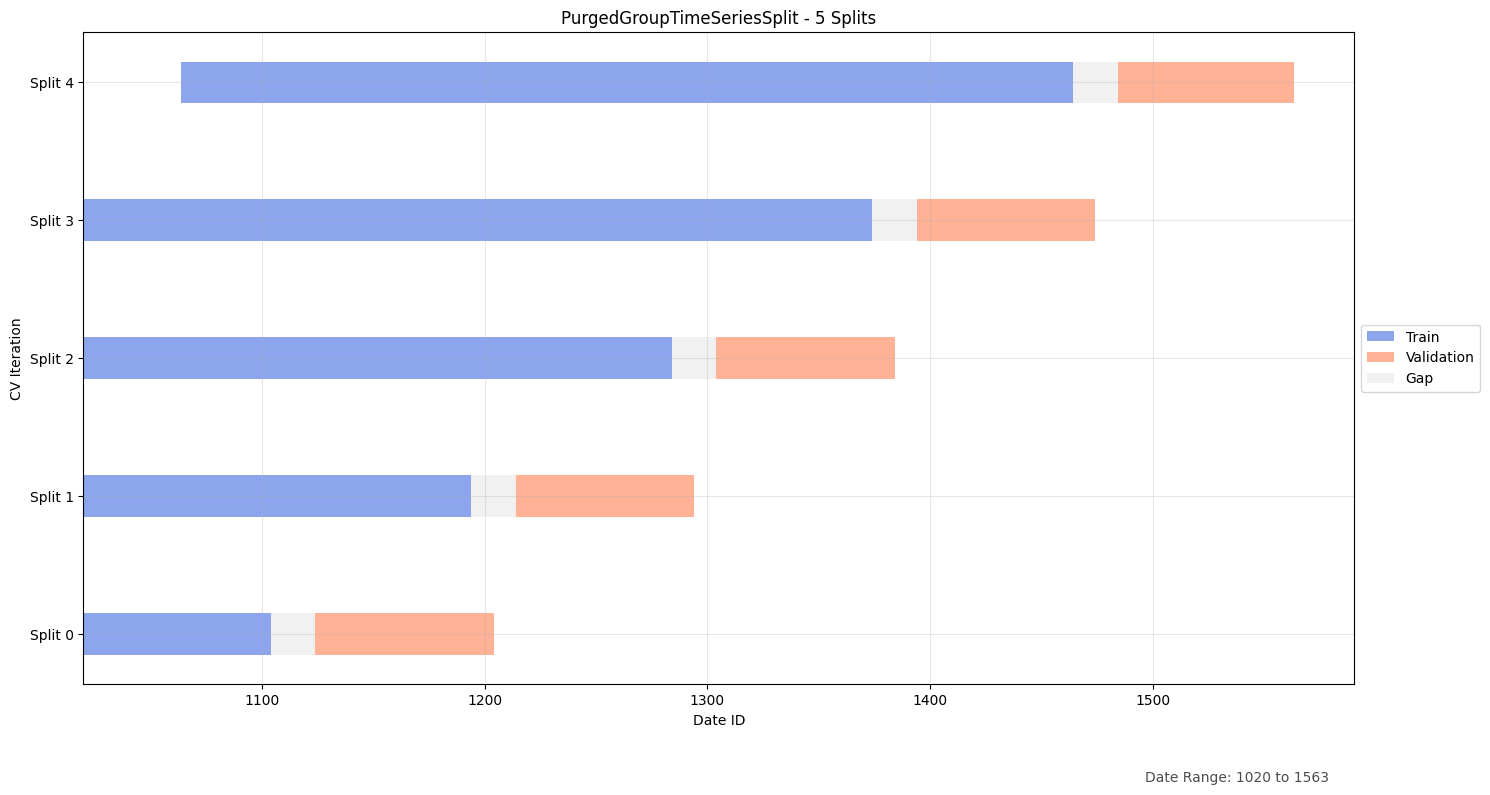


Training fold 1/5

Loading train data from partitions: [6]
Loaded train data shape: (3000800, 92)
Date range in loaded data: 1020 to 1104
Memory usage of dataframe is 1018.25 MB
Memory usage after optimization is: 1018.25 MB
Decreased by 0.0%

Loading train data from partitions: [6, 7]
Loaded train data shape: (3036616, 92)
Date range in loaded data: 1124 to 1204
Memory usage of dataframe is 1030.66 MB
Memory usage after optimization is: 1030.66 MB
Decreased by 0.0%
Training model...

Memory usage before training:
train_X: 3.62 GB
train_y: 0.01 GB

Validation data memory usage:
val_X: 3.67 GB
val_y: 0.01 GB
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40072
[LightGBM] [Info] Number of data points in the train set: 3000800, number of used features: 162
[LightGBM] [Info] Start training from score -0.007358
Training until validation scores don'

100%|██████████| 99.8k/99.8k [00:01<00:00, 69.8kB/s]


Upload successful: jane-street-model-dhv1.pkl (100KB)
Dataset created successfully

Evaluating on holdout test set...
Starting prediction...
Available features: ['feature_symbol_id', 'feature_sin_time_id', 'feature_cos_time_id', 'feature_sin_time_id_halfday', 'feature_cos_time_id_halfday', 'feature_weight', 'feature_73', 'feature_73_rolling_2', 'feature_73_rolling_2_pct_change', 'feature_73_rolling_10', 'feature_73_rolling_10_pct_change', 'feature_73_rolling_30', 'feature_73_rolling_30_pct_change', 'feature_73_rolling_50', 'feature_73_rolling_50_pct_change', 'feature_73_rolling_200', 'feature_73_rolling_200_pct_change', 'feature_73_rolling_500', 'feature_73_rolling_500_pct_change', 'feature_12', 'feature_12_rolling_2', 'feature_12_rolling_2_pct_change', 'feature_12_rolling_10', 'feature_12_rolling_10_pct_change', 'feature_12_rolling_30', 'feature_12_rolling_30_pct_change', 'feature_12_rolling_50', 'feature_12_rolling_50_pct_change', 'feature_12_rolling_200', 'feature_12_rolling_200_pct

In [23]:
INFERENCE_ONLY = False  # True: inference만 실행, False: 학습 포함
OPTIMIZE_HYPERPARAMS = False  # True: 하이퍼파라미터 최적화 실행
NICKNAME = "alvinlee9"  # Kaggle nickname
BASE_DATASET_NAME = "jane-street-model-dhv1"  # Base dataset name
DATASET_NAME = f"{BASE_DATASET_NAME}" if IS_KAGGLE else f"{NICKNAME}/{BASE_DATASET_NAME}"

if INFERENCE_ONLY and IS_KAGGLE:
    # Inference only mode
    print("Running in inference-only mode...")
    pipeline = run_inference_only(DATASET_NAME)
else:
    # Training mode
    config = Config(
        partition_range=[6,7,8,9],
        model=ModelConfig(
            name='lightgbm',
            params={
                'objective': 'regression_l2',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': 0.1,
                'random_state': 42,
                'verbose': 1,
                'device': 'cpu',
            },
            custom_metrics={},
        ),
        dataset_name=DATASET_NAME,
        split_strategy=PurgedGroupTimeSeriesSplit(
            # n_splits=5,
            # group_gap=15,
            # max_train_group_size=200,
            # max_test_group_size=50,
            # test_ratio=0.2,
            n_splits=5,
            group_gap=10,
            max_train_group_size=400,
            max_test_group_size=200,
            test_ratio=0.2,
        ),
        seed=42
    )
    # config = Config(
    #     # partition_range=[6,7,8,9],
    #     model=ModelConfig(
    #         name='xgboost',
    #         params={
    #             'objective': 'reg:squarederror',  # regression task
    #             'eval_metric': 'rmse',            # evaluation metric
    #             'booster': 'gbtree',             # use tree booster
    #             'learning_rate': 0.1,            # eta
    #             'max_depth': 6,                  # maximum tree depth
    #             'min_child_weight': 1,           # minimum sum of instance weight in a child
    #             'subsample': 0.8,                # sampling ratio of training instances
    #             'colsample_bytree': 0.8,         # sampling ratio of columns when constructing each tree
    #             'colsample_bylevel': 0.8,        # sampling ratio of columns for each level
    #             'lambda': 1,                     # L2 regularization
    #             'alpha': 0,                      # L1 regularization
    #             'tree_method': 'hist',           # use histogram-based algorithm
    #             'random_state': 42,
    #             'n_jobs': -1,                    # use all CPU cores
    #             'verbosity': 1,
    #         },
    #         custom_metrics={},
    #     ),
    #     dataset_name=DATASET_NAME,
    #     split_strategy=PurgedGroupTimeSeriesSplit(
    #         n_splits=5,
    #         group_gap=50,
    #         max_train_group_size=400,
    #         max_test_group_size=200,
    #         test_ratio=0.2,
    #     ),
    #     seed=42
    # )
    # config = Config(
        # model=ModelConfig(
    #         name='neural_network',
    #         params={
    #             'hidden_dims': [256, 128, 64],  # Hidden layer dimensions
    #             'dropout': 0.1,                 # Dropout rate
    #             'learning_rate': 1e-3,          # Learning rate
    #             'weight_decay': 1e-5,           # L2 regularization
    #             'batch_size': 1024,             # Batch size
    #             'epochs': 100,                  # Maximum number of epochs
    #             'patience': 10,                 # Early stopping patience
    #         },
    #         custom_metrics={},
    #     ),
    #     dataset_name=DATASET_NAME,
    #     split_strategy=PurgedGroupTimeSeriesSplit(
    #         n_splits=5,
    #         group_gap=50,
    #         max_train_group_size=400,
    #         max_test_group_size=200,
    #         test_ratio=0.2,
    #     ),
    #     seed=42
    # )
    
    pipeline = Pipeline(config)
    
    if not IS_KAGGLE:
        # Local training
        print("Training model locally...")
        holdout_test = pipeline.train(
            preprocessor=default_preprocessor,
            feature_generator=default_feature_generator,
            optimize=OPTIMIZE_HYPERPARAMS,
            n_trials=100 if OPTIMIZE_HYPERPARAMS else None
        )

        print("\nUploading pipeline to Kaggle...")
        pipeline.upload_to_kaggle()

        # Evaluate on holdout test set using R2
        print("\nEvaluating on holdout test set...")
        holdout_test_X, holdout_test_y, holdout_test_w = pipeline.data_handler.get_feature_data(holdout_test)
        holdout_test_pred = pipeline.predict(holdout_test_X)
        
        # Calculate R2 score
        _, r2_score, _ = r2_metric(holdout_test_y, holdout_test_pred, holdout_test_w)
        print(f"Holdout test R2 score: {r2_score:.4f}")
        
        # Predict on competition test set if available
        if pipeline.data_handler.test_data is not None:
            print("\nPredicting on competition test set...")
            raw_test_data = pipeline.data_handler.test_data
            test_data = pipeline.data_handler._process_and_generate_features(raw_test_data)
            print(f"Test data shape: {test_data.shape}")

            test_pred = pipeline.predict(test_data)
            print(f"Test predictions shape: {test_pred.shape}")
            print(test_pred)
        
        # Submit to competition
        
    else:
        # Kaggle training
        print("Training model in Kaggle environment...")
        pipeline.train(
            preprocessor=default_preprocessor,
            feature_generator=default_feature_generator,
            optimize=False
        )

In [24]:
if IS_KAGGLE:
    import kaggle_evaluation.jane_street_inference_server

    if not 'pipeline' in globals():  # pipeline이 아직 정의되지 않은 경우
        # Inference only mode로 가정하고 모델 로드
        pipeline = run_inference_only(DATASET_NAME)
    
    print("Setting up for competition submission...")
    inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(
        predict
    )
    
    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        print("Starting inference server...")
        inference_server.serve()
    else:
        print("Running local gateway...")
        inference_server.run_local_gateway(
            (f'{BASE_PATH}/test.parquet', f'{BASE_PATH}/lags.parquet')
        )


## Custom Experiment Example

In [25]:
"""
# Custom preprocessing and feature generation example
def my_preprocessor(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.col('weight').fill_null(pl.col('weight').mean()),
        pl.col('feature_00').clip(-3, 3),
        pl.col('feature_01').clip(-3, 3),
    ])

def my_feature_generator(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        # Moving statistics
        pl.col('feature_00').rolling_mean(window_size=10).alias('feature_00_ma10'),
        pl.col('feature_00').rolling_std(window_size=10).alias('feature_00_std10'),
        
        # Feature interactions
        (pl.col('feature_02') / (pl.col('feature_03') + 1e-7)).alias('feature_ratio_02_03'),
        
        # Group statistics
        pl.col('feature_00').mean().over('symbol_id').alias('feature_00_symbol_mean'),
    ])

# Run custom experiment
config = Config(...)
pipeline = Pipeline(config)
pipeline.train(
    preprocessor=my_preprocessor,
    feature_generator=my_feature_generator,
    optimize=True
)
"""

"\n# Custom preprocessing and feature generation example\ndef my_preprocessor(df: pl.DataFrame) -> pl.DataFrame:\n    return df.with_columns([\n        pl.col('weight').fill_null(pl.col('weight').mean()),\n        pl.col('feature_00').clip(-3, 3),\n        pl.col('feature_01').clip(-3, 3),\n    ])\n\ndef my_feature_generator(df: pl.DataFrame) -> pl.DataFrame:\n    return df.with_columns([\n        # Moving statistics\n        pl.col('feature_00').rolling_mean(window_size=10).alias('feature_00_ma10'),\n        pl.col('feature_00').rolling_std(window_size=10).alias('feature_00_std10'),\n        \n        # Feature interactions\n        (pl.col('feature_02') / (pl.col('feature_03') + 1e-7)).alias('feature_ratio_02_03'),\n        \n        # Group statistics\n        pl.col('feature_00').mean().over('symbol_id').alias('feature_00_symbol_mean'),\n    ])\n\n# Run custom experiment\nconfig = Config(...)\npipeline = Pipeline(config)\npipeline.train(\n    preprocessor=my_preprocessor,\n    feat